In [1]:
import csv
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt
def readCsv(file):
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        Cat=dict()
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                for i in range(len(row)):
                    try:
                        float(row[i])
                    except ValueError:
                        try:
                            Cat[i].add(row[i])
                        except:
                            Cat[i]=set([row[i]])
        line_count = 0
        d=[]
        csv_file.seek(0)
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                temp=[]
                for i in range(len(row)):
                    try:
                        temp.append(float(row[i]))
                    except ValueError:
                        temp.append(list(Cat[i]).index(row[i]))
                d.append(temp)
    return  np.array(d)
def PCAf(arr, dim):
    mean = np.average(arr, axis=0)
    cov = np.cov(arr, bias=True, rowvar=False)
    eValue, eVectors = np.linalg.eigh(cov)
    evIndices = np.flip(np.argsort(eValue))  # get indices of descending eigenvalues
    U = np.empty((cov.shape[0], 0))
    for i in range(dim):
        ui = eVectors.T[evIndices[i]]
        U = np.column_stack([U, ui])
    A = np.empty((0, dim))
    for xi in arr.values:
        ai = np.matmul(U.T, xi)
        A = np.row_stack([A, ai])
    return A
def kMeans(D,k,eps,mu=None,max_iterations=500):
    t=0
    if not mu:
        mu=[]
        for ki in range(k):
            mu.append(np.random.uniform(D.min(0),D.max(0),len(D.min(0))))
    mun=[mu]
    k=len(mu)
    for l in range(max_iterations):
        t+=1
        c=[]
        for m in range(k):
           c.append([])
        for j in range(D.shape[0]):
            min = np.inf
            temp=0
            for i in range(len(mun[t-1])):
                distancia=np.linalg.norm(D[j]-mun[t-1][i])
                if distancia<min:
                    min=distancia
                    temp=i
            c[temp].append(list(D[j]))
        mu=[]
        for i in range(k):
            sum=np.zeros(len(D[0]))
            for j in c[i]:
                sum+=np.array(j)
            if len(c[i])!=0:
                mu.append(list(sum/len(c[i])))
        mun.append(mu)
        
        error=0
        for i in range(len(mun[t])):
            error+=(abs(np.linalg.norm(np.array(mun[-1][i])- np.array(mun[-2][i]))))**2
        if error < eps:
            break
    print("\t\t tomo",l,"iteraciones")
    return c,mu
def multivariate_normal(x, mean, covariance):
    x_m = x - mean
    d=len(x)
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))
def  EM(D, k, eps, mu = None, independent = False,max_iterations=500):
    n,p=D.shape
    t=0
    cov=[]
    pis=[]
    if not mu:
        mu=[]
        for ki in range(k):
            mu.append(np.random.uniform(D.min(0),D.max(0),p))
    sum=0
    for j in range(k):
        # print(np.linalg.norm(D-mu[j],axis=-1).sum()/n)
        sum+=np.linalg.norm(D-mu[j],axis=-1).sum()/n
    print(sum/k)
    for ki in range(k):
        cov.append(np.identity(p))
        pis.append(1/k)
    mut=[mu]
    for l in range(max_iterations):
        t+=1
        w = np.zeros((k, n))
        #Expectation Step
        for i in range(k):
            for j in range(n):
                w[i, j] = sc.multivariate_normal(mut[t-1][i], cov[i]).pdf(D[j]) *pis[i]
        w = w/w.sum(0)
        #check sum 1
        # print("---",w.sum(0))
            
        #maximization Step
        
        # mu
        mu = np.zeros((k, p))
        for i in range(k):
            for j in range(n):
                mu[i] += w[i, j] * D[j]
            mu[i] /= w[i, :].sum()
        mut.append(mu)
        
        # covariance
        if independent:
            cov = np.zeros((k,  p, p))
            for i in range(k):
                for j in range(n):
                    ys = np.zeros((p, p))
                    np.fill_diagonal(ys, (D[j]- mu[i])**2)
                    cov[i] += w[i,j] * ys
                cov[i] /= w[i,:].sum()
        else:
            cov = np.zeros((k,  p, p))
            for i in range(k):
                for j in range(n):
                    ys = np.reshape(D[j]- mu[i], (p,1))
                    cov[i] += w[i,j] * np.dot(ys, ys.T)
                cov[i] /= w[i,:].sum()
        # pi
        pis = np.zeros(k)
        for j in range(k):
            for i in range(n):
                pis[j] += w[j, i]
        pis /= n
        
        error=0
        for i in range(len(mut[t])):
            error+=(abs(np.linalg.norm(np.array(mut[-1][i])- np.array(mut[-2][i]))))**2
        if error < eps:
            break
    print("\t\t tomo",l,"iteraciones")
    return w, mu, cov

In [2]:
D=readCsv("Mall_Customers.csv")
menor=np.inf
menork=0
print('--------------------------------- K means-----------------------------------')
for k in range(2,5+1):
    print('k=',k)
    for i in range(10):
        print('\t inentento',i+1)
        c,mu=kMeans(D,k,0.001)
        curr_sse=0
        for ci in range(len(c)):
            for p in c[ci]:
                curr_sse+=np.linalg.norm(np.array(p)- np.array(mu[ci]))
        if curr_sse<menor:
            menor=curr_sse
            menork=k
        print('\t\t con diferencia ',curr_sse)
        for mi in range(len(mu)):
            print('\t\t centro',mi+1,'=',mu[mi],'con puntos',c[mi])
    print('\n\tsse=',menor)
    print('\n\n')
print('el mejor k es',menork)

--------------------------------- K means-----------------------------------
k= 2
	 inentento 1
		 tomo 5 iteraciones
		 con diferencia  8314.700686011085
		 centro 1 = [150.0, 0.5247524752475248, 37.772277227722775, 81.35643564356435, 50.45544554455446] con puntos [[100.0, 0.0, 20.0, 61.0, 49.0], [101.0, 1.0, 23.0, 62.0, 41.0], [102.0, 1.0, 49.0, 62.0, 48.0], [103.0, 0.0, 67.0, 62.0, 59.0], [104.0, 0.0, 26.0, 62.0, 55.0], [105.0, 0.0, 49.0, 62.0, 56.0], [106.0, 1.0, 21.0, 62.0, 42.0], [107.0, 1.0, 66.0, 63.0, 50.0], [108.0, 0.0, 54.0, 63.0, 46.0], [109.0, 0.0, 68.0, 63.0, 43.0], [110.0, 0.0, 66.0, 63.0, 48.0], [111.0, 0.0, 65.0, 63.0, 52.0], [112.0, 1.0, 19.0, 63.0, 54.0], [113.0, 1.0, 38.0, 64.0, 42.0], [114.0, 0.0, 19.0, 64.0, 46.0], [115.0, 1.0, 18.0, 65.0, 48.0], [116.0, 1.0, 19.0, 65.0, 50.0], [117.0, 1.0, 63.0, 65.0, 43.0], [118.0, 1.0, 49.0, 65.0, 59.0], [119.0, 1.0, 51.0, 67.0, 43.0], [120.0, 1.0, 50.0, 67.0, 57.0], [121.0, 0.0, 27.0, 67.0, 56.0], [122.0, 1.0, 38.0, 67.0, 40.0

		 tomo 6 iteraciones


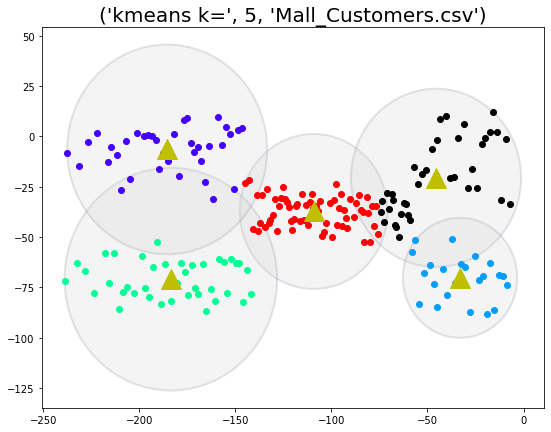

In [3]:
colors =['#ff0000','#000000','#00ff95','#009dff','#4400ff','#736c73']
c,mu=kMeans(PCAf(pd.DataFrame(D), 2),menork,0.01)
fig2d,ax=plt.subplots(figsize=(9,7))
for i in range(len(c)):
    for j in range(len(c[i])):
        plt.plot([c[i][j][0]],[c[i][j][1]], color=colors[i],marker='o')
for i in range(len(c)):
    plt.plot([mu[i][0]],[mu[i][1]], 'y^',markersize=20)
    disx=np.linalg.norm(mu[i] - np.array(c[i]),axis=1).max()
    ax.add_patch(plt.Circle(mu[i],disx, fc='#CCCCCC',edgecolor='slategrey',lw=2, alpha=0.2, zorder=1))
tittulo='kmeans k=',k, "Mall_Customers.csv"
ax.set_title(tittulo,fontsize=20)
plt.show()

In [4]:
# print('--------------------------------- Em dependiente-----------------------------------')
# for k in range(2,5+1):
#     print('k=',k)
#     for i in range(10):
#         print('\t inentento',i+1)
#         w, mu, cov=EM(D,k,0.001)
#         for mi in range(len(mu)):
#             print('\t\t centro',mi+1,'=',mu[mi],'con cov',cov[mi])
#     print('\n\n')

In [5]:
# print('--------------------------------- Em independiente-----------------------------------')
# for k in range(2,5+1):
#     print('k=',k)
#     for i in range(10):
#         print('\t inentento',i+1)
#         w, mu, cov=EM(D,k,0.001,independent=True)
#         for mi in range(len(mu)):
#             print('\t\t centro',mi+1,'=',mu[mi],'con cov',cov[mi])
#     print('\n\n')

--------------------------------- K means riddle-----------------------------------
k= 2
		 tomo 4 iteraciones
		 centro 1 = [0.4982117409483875, 0.5267973384711955, 0.49821065378162305, 0.5115455613933759, 0.5074591865095126, 0.5061401495378718, 0.47188298969895404, 0.4979577529651136, 0.5287725689573328, 0.4998214125975038, 0.517378159237819, 0.5018125971868006, 0.522516394333905, 0.5070503158247875, 0.5071831772771531, 0.5084415564901484, 0.468270167313144, 0.5147889233289413, 0.5142003441407599, 0.4969320904812614, 0.5187767143984602, 0.4960419973254341, 0.48182089754109386, 0.4867618713941659, 0.4964407496496247, 0.5042628225385704, 0.483473709075451, 0.5121834657307136, 0.5170364644288323, 0.5054427316153994, 0.48650451473800144, 0.4908631059775058, 0.5263041772760381, 0.5027353649554359, 0.49504999782860065, 0.4977974049420341, 0.4969115522594903, 0.4923076957949357, 0.49686001746291314, 0.5240020185513444, 0.5089779345274859, 0.4833504078440287, 1.2179034597178546, 0.5170654084

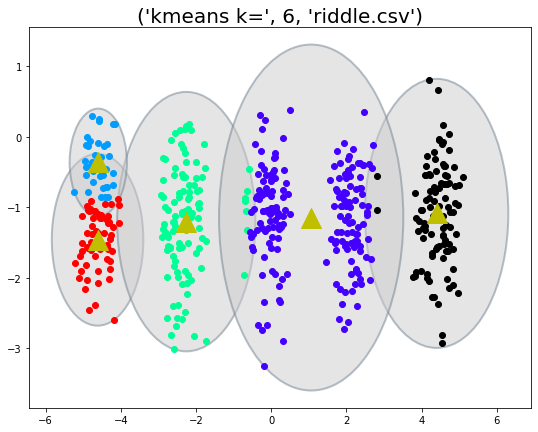

In [6]:
D=readCsv("riddle.csv")
print('--------------------------------- K means riddle-----------------------------------')
menor=np.inf
menork=0
for k in range(2,6+1):
    print('k=',k)
    c,mu=kMeans(D,k,0.001)
    curr_sse=0
    for ci in range(len(c)):
        for p in c[ci]:
            curr_sse+=np.linalg.norm(np.array(p)- np.array(mu[ci]))
    if curr_sse<menor:
        menor=curr_sse
        menork=k
    for mi in range(len(mu)):
        print('\t\t centro',mi+1,'=',mu[mi])
print('el mejor k es',menork)
c,mu=kMeans(PCAf(pd.DataFrame(D), 2),menork,0.01)
fig2d,ax=plt.subplots(figsize=(9,7))
for i in range(len(c)):
    for j in range(len(c[i])):
        plt.plot([c[i][j][0]],[c[i][j][1]], c=colors[i],marker='o')
for i in range(len(c)):
    plt.plot([mu[i][0]],[mu[i][1]], 'y^',markersize=20)
    disx=np.linalg.norm(mu[i] - np.array(c[i]),axis=1).max()
    ax.add_patch(plt.Circle(mu[i],disx, fc='#CCCCCC',edgecolor='slategrey',lw=2, alpha=0.5, zorder=1))
tittulo='kmeans k=',k, "riddle.csv"
ax.set_title(tittulo,fontsize=20)
plt.show()

		 tomo 3 iteraciones


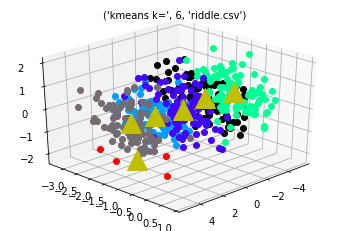

In [7]:
c,mu=kMeans(PCAf(pd.DataFrame(D), 3),k,0.01)
fig3d = plt.figure()
ax = fig3d.add_subplot(111, projection='3d')
for i in range(len(c)):
    for j in range(len(c[i])):
        ax.plot([c[i][j][0]],[c[i][j][1]],[c[i][j][2]], c=colors[i],marker='o')
for i in range(len(c)):
    ax.plot([mu[i][0]],[mu[i][1]],[mu[i][2]], 'y^',markersize=20)
ax.view_init(30, 45)
ax.set_title(tittulo,fontsize=10)
plt.show()

--------------------------------- K means delayed flights-----------------------------------
k= 2
		 tomo 10 iteraciones
		 centro 1 = [2008.0, 1.0, 9.94108669108669, 4.492368742368742, 1620.9589438339437, 1547.657203907204, 1680.7971611721612, 1698.270757020757, 0.0, 768.5198412698413, 256.0583028083028, 105.2014652014652, 106.02564102564102, 87.73794261294262, 45.76205738705739, 46.586233211233214, 28.372252747252748, 28.386752136752136, 592.8644688644689, 5.169871794871795, 12.293650793650794, 0.0, 0.0, 0.0, 10.677350427350428, 1.5576923076923077, 5.531593406593407, 0.13873626373626374, 27.85668498168498]
		 centro 2 = [2008.0, 1.0, 10.353538283062646, 4.509860788863109, 1663.8645591647332, 1589.1690835266822, 1684.8396171693735, 1704.8332366589327, 0.0, 2824.8961716937356, 254.31235498839908, 107.73839907192576, 108.91241299303944, 90.23723897911833, 46.178074245939676, 47.35208816705337, 28.215777262180975, 28.80365429234339, 611.3793503480279, 5.123259860788863, 12.37790023201856

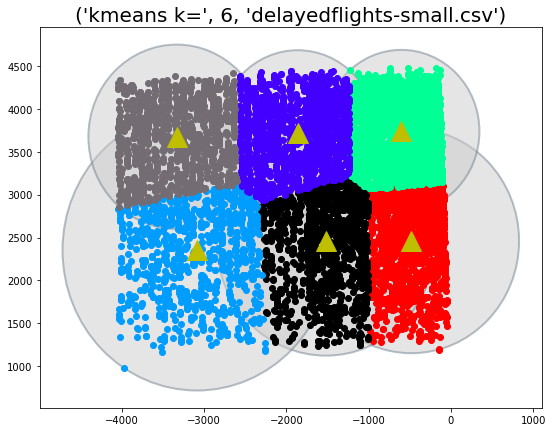

In [8]:
D=readCsv("delayedflights-small.csv")
print('--------------------------------- K means delayed flights-----------------------------------')
menor=np.inf
menork=0
for k in range(2,6+1):
    print('k=',k)
    c,mu=kMeans(D,k,0.001)
    curr_sse=0
    for ci in range(len(c)):
        for p in c[ci]:
            curr_sse+=np.linalg.norm(np.array(p)- np.array(mu[ci]))
    if curr_sse<menor:
        menor=curr_sse
        menork=k
    for mi in range(len(mu)):
        print('\t\t centro',mi+1,'=',mu[mi])
print('el mejor k es',menork)
c,mu=kMeans(PCAf(pd.DataFrame(D), 2),menork,0.01)
fig2d,ax=plt.subplots(figsize=(9,7))
for i in range(len(c)):
    for j in range(len(c[i])):
        plt.plot([c[i][j][0]],[c[i][j][1]], c=colors[i],marker='o')
for i in range(len(c)):
    plt.plot([mu[i][0]],[mu[i][1]], 'y^',markersize=20)
    disx=np.linalg.norm(mu[i] - np.array(c[i]),axis=1).max()
    ax.add_patch(plt.Circle(mu[i],disx, fc='#CCCCCC',edgecolor='slategrey',lw=2, alpha=0.5, zorder=1))
tittulo='kmeans k=',k, "delayedflights-small.csv"
ax.set_title(tittulo,fontsize=20)
plt.show()

		 tomo 36 iteraciones


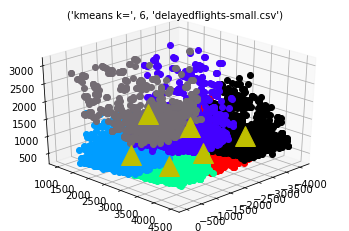

In [9]:
c,mu=kMeans(PCAf(pd.DataFrame(D), 3),k,0.01)
fig3d = plt.figure()
ax = fig3d.add_subplot(111, projection='3d')
for i in range(len(c)):
    for j in range(len(c[i])):
        ax.plot([c[i][j][0]],[c[i][j][1]],[c[i][j][2]], c=colors[i],marker='o')
for i in range(len(c)):
    ax.plot([mu[i][0]],[mu[i][1]],[mu[i][2]], 'y^',markersize=20)
ax.view_init(30, 45)
ax.set_title(tittulo,fontsize=10)
plt.show()

In [ ]:
'''
Primero realizar k-means con los datos originales y luego proyectarlos con PCA
La proyeccion hace que los clusters se pierdan y no me parece una buena represntacion
asi que por eso en los puntos superiores primero lo proyecto y luego aplico el algoritmo 
'''
from sklearn.decomposition import IncrementalPCA
colors =['#ff0000','#000000','#00ff95','#009dff','#4400ff','#736c73']
D=readCsv("Mall_Customers.csv")
c,mu=kMeans(D,5,0.001)
puntos=[]
n_batches = 2
inc_pca = IncrementalPCA(n_components=2)
for i in range(len(mu)):
    for X_batch in np.array_split(c[i],n_batches ):
        inc_pca.partial_fit(X_batch)
    X_ipca = inc_pca.transform(c[i])
    X_ipca_reconst = inc_pca.inverse_transform(X_ipca)
    puntos.append(X_ipca_reconst)
X_pca = pca.fit_transform(mu)
X_pca_reconst = pca.inverse_transform(X_pca)
medias=X_pca_reconst
fig2d,ax=plt.subplots(figsize=(6,6))
for i in range(len(puntos)):
    for j in range(len(puntos[i])):
        plt.plot([puntos[i][j][0]],[puntos[i][j][1]],color=colors[i],marker='o')
for i in range(len(medias)):
    plt.plot([medias[i][0]],[medias[i][1]], color='y',marker='^',markersize=20)